In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

from tqdm import tqdm

# Configuration
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DATA_DIR = '/kaggle/input/utkface-dataset-20-margin3-side-align/utkface-cropped-margin20(3 side)-alignment-no_whitespace'
DATA_DIR = '/kaggle/input/utkface-dataset-20-margin3-side-align'

print(DEVICE)


cuda


In [2]:
# 1. Parse Filenames
def parse_dataset(data_dir):
    images = []
    ages = []
    genders = []
    races = []

    limit = 0 # for debugging only
    
    for file in os.listdir(data_dir):

        # if limit > 1000 :
        #     print(f"current limit : {limit}")
        #     break
        
        split = file.split('_')
        if len(split) != 4:
            print('skipping : ' + file)
            continue  
        try:
            age = int(split[0])
            gender = int(split[1])
            race = int(split[2])
            
            images.append(os.path.join(data_dir, file))
            ages.append(age)
            genders.append(gender)
            races.append(race)
            
            limit += 1
        except Exception as e:
            # print(e)
            continue # Skip bad files

    df = pd.DataFrame({
        'image': images,
        'age': ages,
        'gender': genders,
        'race': races,
    })
    return df


In [3]:
# 2. Create Dataset Class
class UTKFaceDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['image']
        
        # Read Image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        if self.transform:
            image = self.transform(image)
            
        # Return dictionary of labels
        labels = {
            'age': torch.tensor(row['age'], dtype=torch.float32),
            'gender': torch.tensor(row['gender'], dtype=torch.float32), # Float for BCE Loss
            'race': torch.tensor(row['race'], dtype=torch.long),         # Long for CrossEntropy
        }
        
        return image, labels

# 3. Transforms
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
# Prepare Data
df = parse_dataset(DATA_DIR)

train_df, val_df = train_test_split(df, test_size=0.4, random_state=42) # full df 60 : 40
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42) # test df 50 : 50

train_full_dataset = UTKFaceDataset(train_df, train_transforms)
val_full_dataset = UTKFaceDataset(val_df, val_transforms)
test_full_dataset = UTKFaceDataset(test_df, val_transforms)


skipping : 39_1_20170116174525125.jpg
skipping : 61_1_20170109142408075.jpg
skipping : 61_3_20170109150557335.jpg


In [5]:
# train_loader = DataLoader(train_full_dataset, batch_size=BATCH_SIZE, sampler=sampler_race, shuffle=False)
train_loader = DataLoader(train_full_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_full_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_full_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
print(f"Training set size : {len(train_full_dataset)} \nValidation set size : {len(val_full_dataset)} \nTest set size : {len(test_full_dataset)}")

Training set size : 14461 
Validation set size : 4820 
Test set size : 4821


In [7]:
# df = test_full_dataset.df

# Define labels for plots
gender_map = {0: 'Male', 1: 'Female'}
race_map = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Other'}

# Replace numeric codes with readable labels for plotting
df['gender_label'] = df['gender'].map(gender_map)
df['race_label'] = df['race'].map(race_map)
df.head()

,image,age,gender,race,gender_label,race_label
0,/kaggle/input/utkface-dataset-20-margin3-side-...,42,0,0,Male,White
1,/kaggle/input/utkface-dataset-20-margin3-side-...,88,0,2,Male,Asian
2,/kaggle/input/utkface-dataset-20-margin3-side-...,35,1,0,Female,White
3,/kaggle/input/utkface-dataset-20-margin3-side-...,26,0,3,Male,Indian
4,/kaggle/input/utkface-dataset-20-margin3-side-...,42,1,1,Female,Black


/tmp/ipykernel_24/1268519830.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='gender_label', data=df, ax=axes[1], palette='pastel')
/tmp/ipykernel_24/1268519830.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='race_label', data=df, ax=axes[2], palette='viridis', order=df['race_label'].value_counts().index)


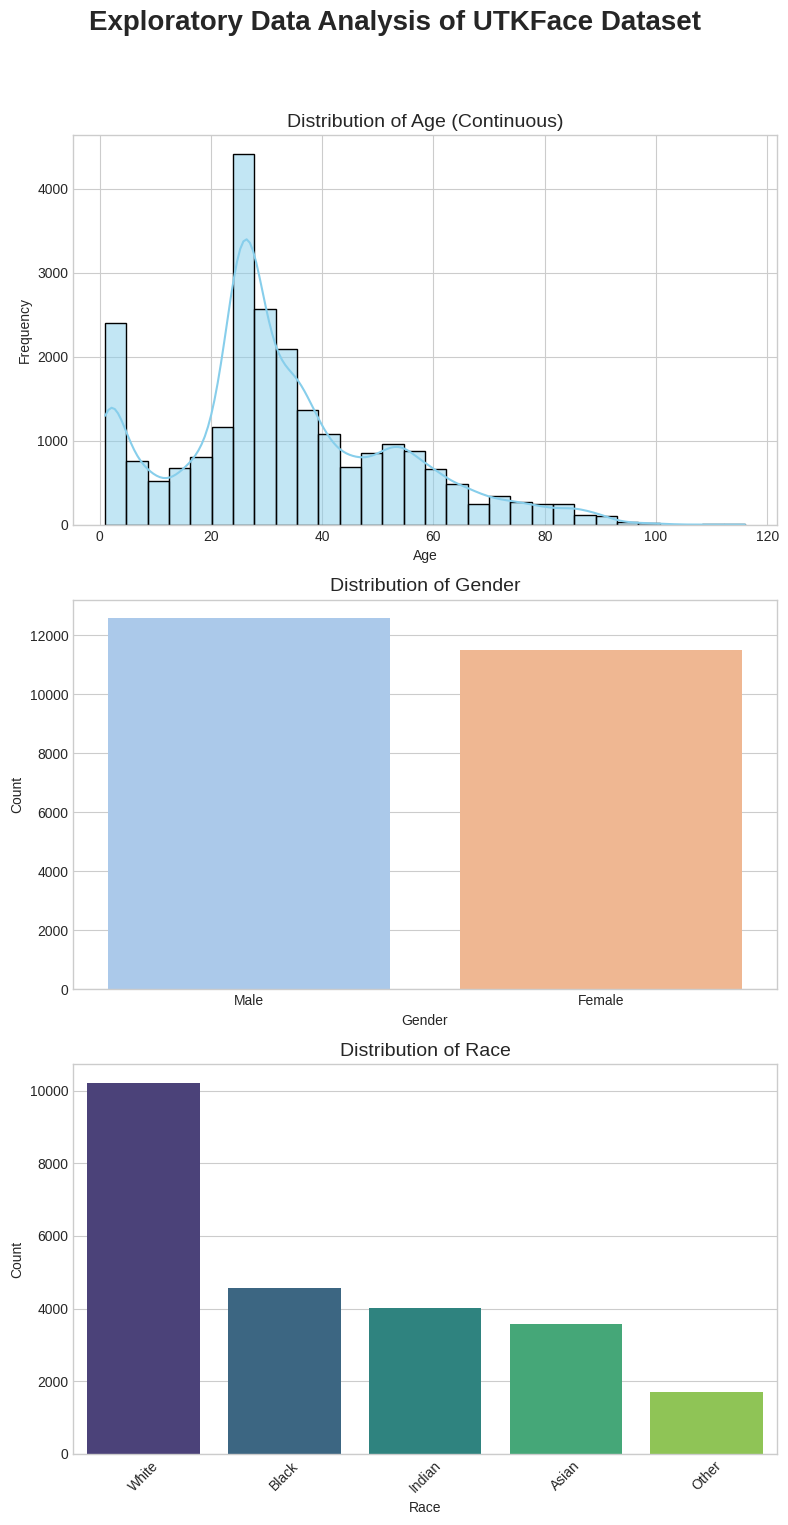

\nDisplaying some sample images with their labels...
Plot saved as EDA.png


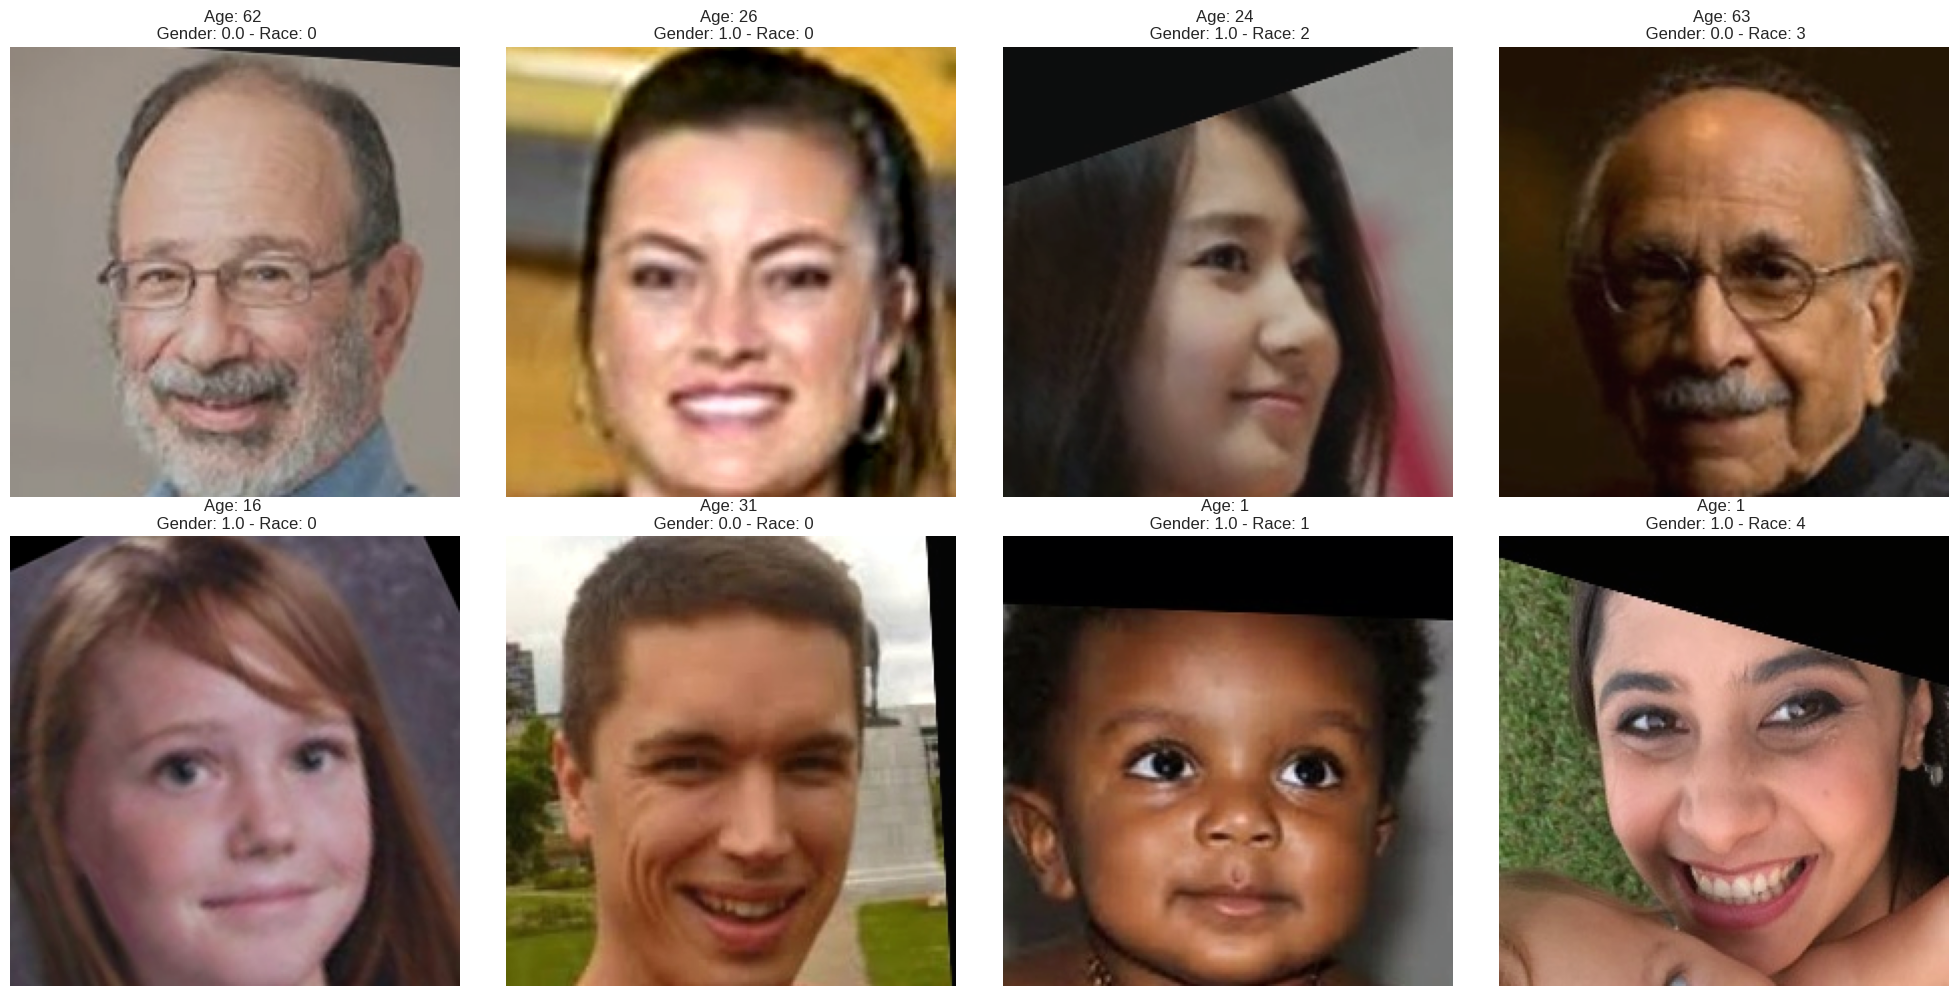

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 2. Plot the Distributions ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 16))
fig.suptitle('Exploratory Data Analysis of UTKFace Dataset', fontsize=20, weight='bold')
axes = axes.flatten()

# Plot 1: Age Distribution (Continuous)
sns.histplot(df['age'], bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Age (Continuous)', fontsize=14)
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')

# Plot 2: Gender Distribution
sns.countplot(x='gender_label', data=df, ax=axes[1], palette='pastel')
axes[1].set_title('Distribution of Gender', fontsize=14)
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Count')

# Plot 3: Race Distribution
sns.countplot(x='race_label', data=df, ax=axes[2], palette='viridis', order=df['race_label'].value_counts().index)
axes[2].set_title('Distribution of Race', fontsize=14)
axes[2].set_xlabel('Race')
axes[2].set_ylabel('Count')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# --- 3. Display Sample Images ---
print("\\nDisplaying some sample images with their labels...")

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
    # Get a sample from the dataset
    img, label = train_full_dataset[i]

    # We need to un-normalize the image to display it correctly
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)
    title = f"Age: {int(label['age'])} \n Gender: {label['gender']} - Race: {label['race']}"
    ax.set_title(title)
    ax.axis('off')

plt.savefig("EDA.png", dpi=300)
# fig.savefig("EDA.png", dpi=300) # Incase the above line doest work
print("Plot saved as EDA.png")

plt.tight_layout()
plt.show()



In [9]:
# 4. Define Multi-Task EfficientNetV2
class MultiTaskEfficientNet(nn.Module):
    def __init__(self, pretrained=True):
        super(MultiTaskEfficientNet, self).__init__()
        
        # Load Pretrained EfficientNetV2-S
        weights = models.EfficientNet_V2_S_Weights.DEFAULT if pretrained else None
        self.backbone = models.efficientnet_v2_s(weights=weights)
            
        # The classifier of EfficientNetV2 is a Sequential block. 
        # We need the input features of the last linear layer.
        # usually self.backbone.classifier[1] is the Linear layer.
        in_features = self.backbone.classifier[1].in_features
        
        # Remove the existing classifier to get raw features
        self.backbone.classifier = nn.Identity()
        
        # --- Define Heads ---
        
        # 1. Age Head (Regression: 1 output)
        self.age_head = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1) 
        )
        
        # 2. Gender Head (Classification: 2 classes)
        self.gender_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )
        
        # 3. Race Head (Classification: 5 classes)
        self.race_head = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 5)
        )

    def forward(self, x):
        # Get shared features from backbone
        features = self.backbone(x)
        
        # Pass features to each head
        age_pred = self.age_head(features)
        gender_pred = self.gender_head(features)
        race_pred = self.race_head(features)
        
        return {
            'age': age_pred,
            'gender': gender_pred,
            'race': race_pred,
        }
        

    def unfreeze_all(self):
        """Unfreezes all parameters for full training."""
        for param in self.parameters():
            param.requires_grad = True

    def unfreeze_backbone(self):
        """Unfreezes all parameters from backbone"""
        for param in self.parameters():
            param.requires_grad = True
    
    def freeze_backbone(self):
        """Freezes the backbone (feature extractor) only."""
        for param in self.backbone.parameters():
            param.requires_grad = False
            
    def unfreeze_partial(self):
        for name, param in model.backbone.named_parameters():
            if "blocks.6" in name or "blocks.5" in name:
                param.requires_grad = True

In [10]:
class RMSELoss(nn.Module):
    """
    Root Mean Square Loss (RMSL) as defined in Equation 2.
    It is designed to give more weight to errors in younger ages by reducing
    the impact of large errors typical in older age groups[cite: 202].
    """
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, pred, actual):
        # Calculate MSE first: (1/N) * sum((y - y_hat)^2)
        mse_loss = self.mse(pred, actual)
        # Apply square root as per Equation 2: RMSL = sqrt(MSE)
        return torch.sqrt(mse_loss + 1e-6) # Added epsilon for numerical stability

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SquaredHingeLoss(nn.Module):
    def __init__(self):
        super(SquaredHingeLoss, self).__init__()

    def forward(self, pred, actual):
        """
        pred: Tensor of shape [Batch_Size, Num_Classes] (e.g., [32, 5])
        actual: Tensor of shape [Batch_Size] containing class indices (e.g., [0, 2, 4...])
                OR [Batch_Size, Num_Classes] if already one-hot.
        """
        
        # 1. Check if actuals are just indices (1D tensor). 
        # If so, convert them to One-Hot Encoding to match 'pred' shape.
        if actual.dim() == 1:
            # Result shape: [32, 5]
            actual = F.one_hot(actual.long(), num_classes=pred.size(1))
        
        # 2. Convert to Float and adjust range for Hinge Loss
        # The paper uses One-Hot (0 and 1). 
        # For Hinge Loss math, we typically want targets to be -1 and 1.
        y_target = actual.float()
        
        # Map 0 -> -1 and 1 -> 1
        y_target = 2 * y_target - 1 

        # 3. Calculate Squared Hinge Loss
        # Formula: (max(0, 1 - y_true * y_pred))^2
        hinge_loss = torch.clamp(1 - y_target * pred, min=0)
        squared_hinge = torch.pow(hinge_loss, 2)
        
        # Return the mean over the batch
        return torch.mean(squared_hinge)

In [12]:
# Initialize Model
# model = MultiTaskEfficientNet(pretrained=True).to(DEVICE)
# model = MultiTaskResNet(version='resnet50', pretrained=True).to(DEVICE)
model = MultiTaskEfficientNet(pretrained=True).to(DEVICE)

print("Initialized EfficientNet-v2 Multi-Task Model")

# model.freeze_backbone()
model.unfreeze_backbone() 
print("Model unfreeze.")

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 125MB/s]


Initialized EfficientNet-v2 Multi-Task Model
Model unfreeze.


In [13]:
# 5. Loss Functions & Optimizer
LEARNING_RATE = 1e-4

# Loss functions
# criterion_age = nn.MSELoss()           # For regression age
criterion_age = RMSELoss()           # For regression age
criterion_gender = nn.BCEWithLogitsLoss() # For multi-class classification gender
criterion_race = SquaredHingeLoss() # For multi-class classification(imbalance) race
# criterion_race = nn.CrossEntropyLoss() # For multi-class classification(imbalance) race

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning Rate Scheduler (Optional but recommended)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

In [14]:
def train_one_epoch(model, loader, optimizer, device, age_criterion, gender_criterion, race_criterion):
    model.train()
    running_loss = 0.0
    
    for images, labels in tqdm(loader, desc="Training"):
        images = images.to(device)
        
        # --- FIX 1: Normalize Age Target (0-100 -> 0.0-1.0) ---
        # This prevents Age loss from overpowering Gender/Race losses
        age_target = labels['age'].to(device).float() / 100.0
        
        gender_target = labels['gender'].to(device)
        race_target = labels['race'].to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        # --- FIX 2: Explicit Shapes .view(-1, 1) ---
        loss_age = age_criterion(outputs['age'].view(-1, 1), age_target.view(-1, 1))
        loss_gender = gender_criterion(outputs['gender'].view(-1, 1), gender_target.view(-1, 1)) # for binary classification
        # loss_gender = gender_criterion(outputs['gender'], gender_target) # for multi-class classification
        loss_race = race_criterion(outputs['race'], race_target)
        
        # Balanced Loss Sum
        # total_loss = (loss_age * 0.2) + (loss_gender * 0.2) + (loss_race * 0.6)
        total_loss = (loss_age) + (loss_gender) + (loss_race)
        
        total_loss.backward()
        optimizer.step()
        
        running_loss += total_loss.item()
        
    return running_loss / len(loader)

In [15]:
def validate(model, loader, device, age_criterion, gender_criterion, race_criterion):
    model.eval()
    running_loss = 0.0
    
    # Metrics
    age_mae = 0.0
    gender_acc = 0.0
    race_acc = 0.0
    total_samples = 0
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation", leave=False):
            images = images.to(device)
            
            # Load targets
            raw_age_target = labels['age'].to(device).float()
            gender_target = labels['gender'].to(device)
            race_target = labels['race'].to(device)
            
            outputs = model(images)
            
            # --- 1. Calculate Loss (Using Normalized Age) ---
            # We divide target by 100 to match the model's new training range
            loss_age = age_criterion(outputs['age'].view(-1, 1), (raw_age_target / 100.0).view(-1, 1))
            
            loss_gender = gender_criterion(outputs['gender'].view(-1, 1), gender_target.view(-1, 1)) # for binary classfication
            # loss_gender = gender_criterion(outputs['gender'], gender_target) # for multi-class classfication
            loss_race = race_criterion(outputs['race'], race_target)
            
            # total_loss = (loss_age * 0.2) + (loss_gender * 0.2) + (loss_race * 0.6)
            total_loss = (loss_age) + (loss_gender) + (loss_race)
            
            running_loss += total_loss.item()
            
            # --- 2. Calculate Metrics ---
            
            # Age MAE: Multiply model output by 100 to get "Years"
            pred_age_years = outputs['age'].view(-1) * 100.0
            age_mae += torch.abs(pred_age_years - raw_age_target.view(-1)).sum().item()
            
            # Gender Accuracy
            #  Binary accuracy
            gender_preds = (torch.sigmoid(outputs['gender'].view(-1, 1)) > 0.5).float()
            gender_acc += (gender_preds == gender_target.view(-1, 1)).sum().item()
            
            #  Multi-class accuracy
            # _, gender_preds = torch.max(outputs['gender'], 1)
            # gender_acc += (gender_preds == gender_target).sum().item()
            
            # Race Accuracy
            _, race_preds = torch.max(outputs['race'], 1)
            race_acc += (race_preds == race_target).sum().item()

            total_samples += images.size(0)

    return (
        running_loss / len(loader),        # Avg Loss
        age_mae / total_samples,           # Avg MAE (Years)
        gender_acc / total_samples,        # Avg Gender Acc (0.0-1.0)
        race_acc / total_samples,          # Avg Race Acc (0.0-1.0)
    )

In [16]:
# Initialize History Dictionary
history = {
    'train_loss': [],
    'val_loss': [],
    'val_age_mae': [],
    'val_gender_acc': [],
    'val_race_acc': [],
}

best_val_loss = float('inf')
patience = 8  # How many epochs to wait after loss stops improving
epochs_no_improve = 0


print("Starting Training...")
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    
    # Run Training and Validation
    train_loss = train_one_epoch(model, train_loader, optimizer, DEVICE, criterion_age, criterion_gender, criterion_race)
    val_loss, val_mae, val_gen_acc, val_race_acc = validate(model, val_loader, DEVICE, criterion_age, criterion_gender, criterion_race)
    
    # Update Scheduler
    scheduler.step(val_loss)
    
    # --- SAVE METRICS ---
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_age_mae'].append(val_mae)
    history['val_gender_acc'].append(val_gen_acc)
    history['val_race_acc'].append(val_race_acc)
    
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Val Age MAE: {val_mae:.2f} years | Gender Acc: {val_gen_acc:.2%} | Race Acc: {val_race_acc:.2%}")
    
    # Save Best Model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_utkface_model.pth")
        print("Model Saved!")
    else:
        epochs_no_improve += 1
        print(f"No improvement in val_loss for {epochs_no_improve} epochs.")

    if epochs_no_improve >= patience:
        print(f"Stopping early after {patience} epochs with no improvement.")
        break  # Exit the training loop
    # --- END OF EARLY STOPPING LOGIC ---
    print("-" * 30)

Starting Training...
Epoch 1/30


Training: 100%|██████████| 451/451 [03:19<00:00,  2.26it/s]


Train Loss: 1.1103 | Val Loss: 0.5907
Val Age MAE: 11.18 years | Gender Acc: 91.83% | Race Acc: 80.58%
Model Saved!
------------------------------
Epoch 2/30


Training: 100%|██████████| 451/451 [02:46<00:00,  2.71it/s]


Train Loss: 0.6361 | Val Loss: 0.4763
Val Age MAE: 7.85 years | Gender Acc: 93.57% | Race Acc: 83.88%
Model Saved!
------------------------------
Epoch 3/30


Training: 100%|██████████| 451/451 [02:36<00:00,  2.88it/s]


Train Loss: 0.4765 | Val Loss: 0.4577
Val Age MAE: 7.30 years | Gender Acc: 94.36% | Race Acc: 84.96%
Model Saved!
------------------------------
Epoch 4/30


Training: 100%|██████████| 451/451 [02:37<00:00,  2.86it/s]


Train Loss: 0.3769 | Val Loss: 0.4489
Val Age MAE: 6.09 years | Gender Acc: 94.52% | Race Acc: 85.10%
Model Saved!
------------------------------
Epoch 5/30


Training: 100%|██████████| 451/451 [02:37<00:00,  2.86it/s]


Train Loss: 0.3125 | Val Loss: 0.4585
Val Age MAE: 5.88 years | Gender Acc: 94.13% | Race Acc: 84.71%
No improvement in val_loss for 1 epochs.
------------------------------
Epoch 6/30


Training: 100%|██████████| 451/451 [02:39<00:00,  2.83it/s]


Train Loss: 0.2574 | Val Loss: 0.5268
Val Age MAE: 5.87 years | Gender Acc: 92.80% | Race Acc: 85.15%
No improvement in val_loss for 2 epochs.
------------------------------
Epoch 7/30


Training: 100%|██████████| 451/451 [02:40<00:00,  2.81it/s]


Train Loss: 0.2197 | Val Loss: 0.5222
Val Age MAE: 6.06 years | Gender Acc: 94.13% | Race Acc: 84.34%
No improvement in val_loss for 3 epochs.
------------------------------
Epoch 8/30


Training: 100%|██████████| 451/451 [02:38<00:00,  2.85it/s]


Train Loss: 0.1928 | Val Loss: 0.5222
Val Age MAE: 5.87 years | Gender Acc: 93.90% | Race Acc: 84.42%
No improvement in val_loss for 4 epochs.
------------------------------
Epoch 9/30


Training: 100%|██████████| 451/451 [02:37<00:00,  2.87it/s]


Train Loss: 0.1772 | Val Loss: 0.5301
Val Age MAE: 5.97 years | Gender Acc: 94.32% | Race Acc: 85.46%
No improvement in val_loss for 5 epochs.
------------------------------
Epoch 10/30


Training: 100%|██████████| 451/451 [02:39<00:00,  2.83it/s]


Train Loss: 0.1554 | Val Loss: 0.5714
Val Age MAE: 5.64 years | Gender Acc: 93.94% | Race Acc: 85.12%
No improvement in val_loss for 6 epochs.
------------------------------
Epoch 11/30


Training: 100%|██████████| 451/451 [02:38<00:00,  2.85it/s]


Train Loss: 0.1233 | Val Loss: 0.5337
Val Age MAE: 5.45 years | Gender Acc: 94.65% | Race Acc: 86.66%
No improvement in val_loss for 7 epochs.
------------------------------
Epoch 12/30


Training: 100%|██████████| 451/451 [02:38<00:00,  2.85it/s]
                                                             

Train Loss: 0.1069 | Val Loss: 0.5239
Val Age MAE: 5.29 years | Gender Acc: 95.04% | Race Acc: 85.93%
No improvement in val_loss for 8 epochs.
Stopping early after 8 epochs with no improvement.


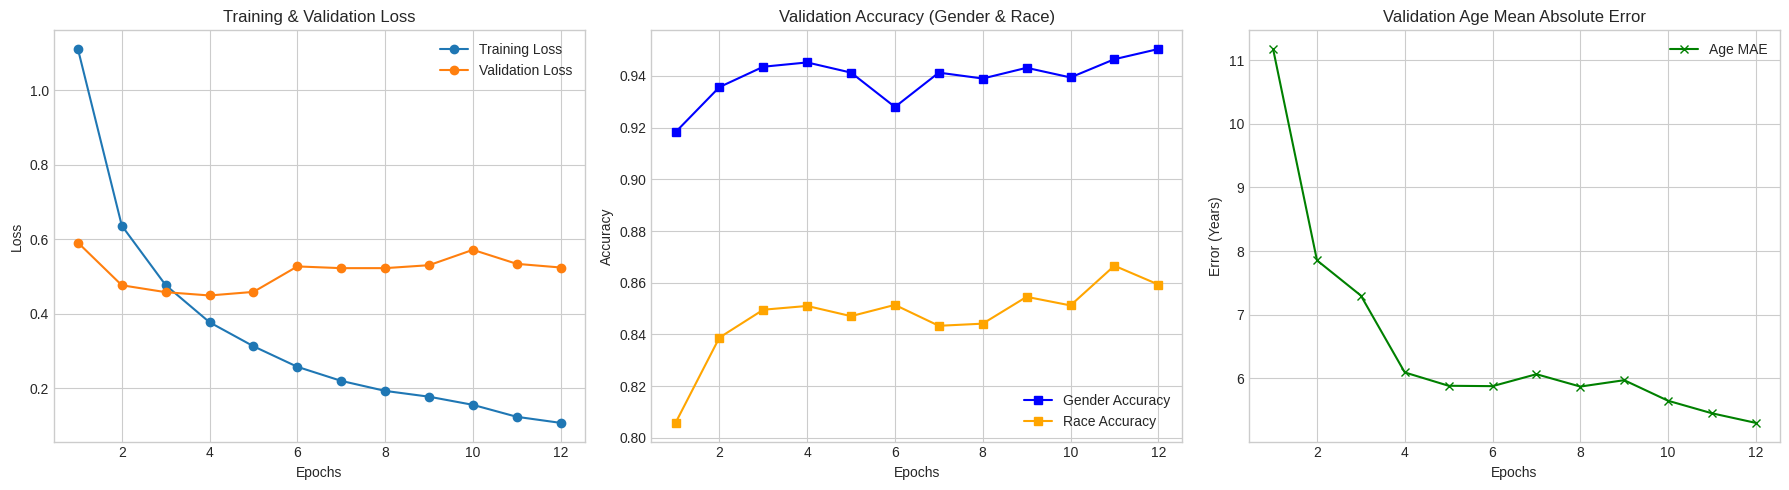

In [17]:
import matplotlib.pyplot as plt

# Create a range for the x-axis (epochs)
epochs_range = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(18, 5))

# --- Plot 1: Loss Curve ---
plt.subplot(1, 3, 1)
plt.plot(epochs_range, history['train_loss'], label='Training Loss', marker='o')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- Plot 2: Classification Accuracy ---
plt.subplot(1, 3, 2)
plt.plot(epochs_range, history['val_gender_acc'], label='Gender Accuracy', marker='s', color='blue')
plt.plot(epochs_range, history['val_race_acc'], label='Race Accuracy', marker='s', color='orange')
plt.title('Validation Accuracy (Gender & Race)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# --- Plot 3: Age Regression Error (MAE) ---
plt.subplot(1, 3, 3)
plt.plot(epochs_range, history['val_age_mae'], label='Age MAE', marker='x', color='green')
plt.title('Validation Age Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('Error (Years)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluation

Mengumpulkan prediksi...


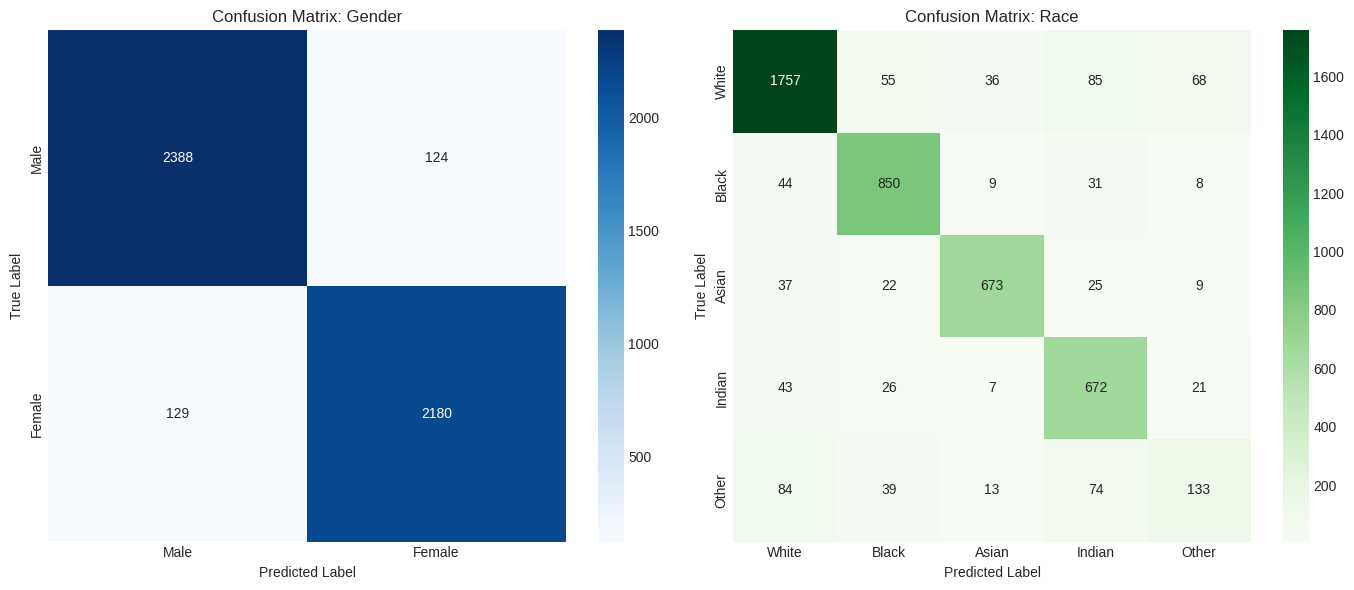


Classification Report (Gender):
              precision    recall  f1-score   support

        Male       0.95      0.95      0.95      2512
      Female       0.95      0.94      0.95      2309

    accuracy                           0.95      4821
   macro avg       0.95      0.95      0.95      4821
weighted avg       0.95      0.95      0.95      4821


Classification Report (Race):
              precision    recall  f1-score   support

       White       0.89      0.88      0.89      2001
       Black       0.86      0.90      0.88       942
       Asian       0.91      0.88      0.89       766
      Indian       0.76      0.87      0.81       769
       Other       0.56      0.39      0.46       343

    accuracy                           0.85      4821
   macro avg       0.80      0.78      0.79      4821
weighted avg       0.84      0.85      0.84      4821



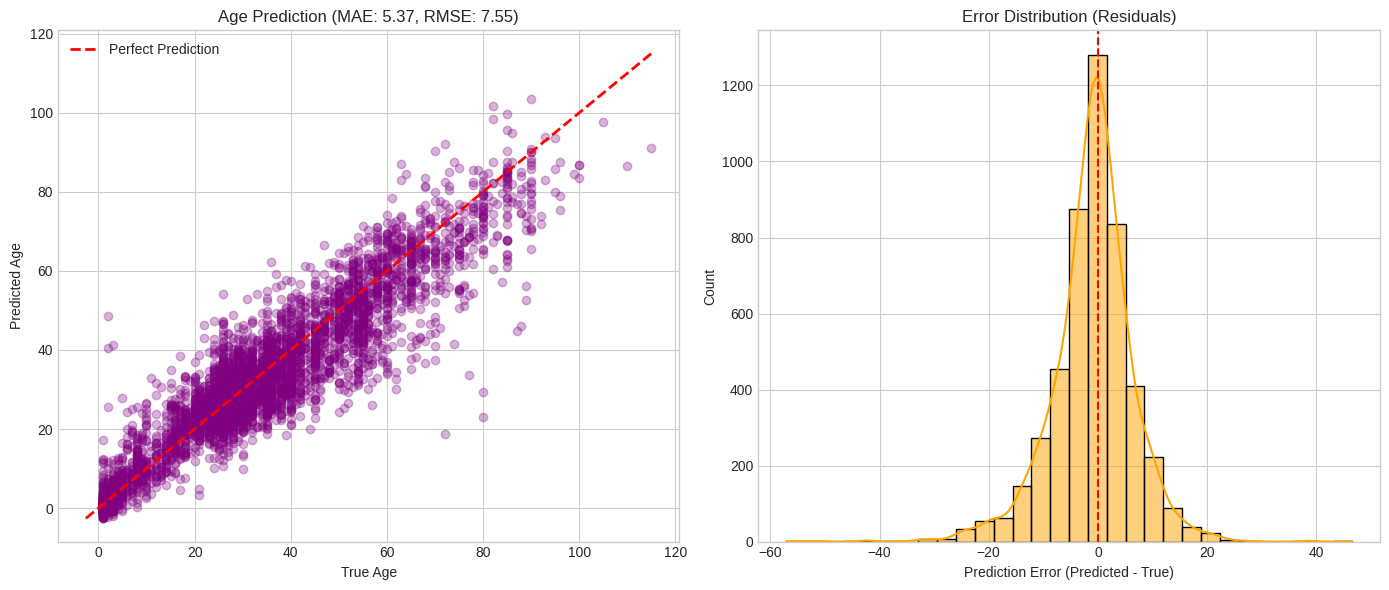

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_absolute_error, mean_squared_error, classification_report

# 1. Fungsi untuk mengumpulkan semua prediksi dari Validation Loader

def get_all_predictions(model, loader, device):
    model.eval()
    
    true_ages, pred_ages = [], []
    true_genders, pred_genders = [], []
    true_races, pred_races = [], []
    
    print("Mengumpulkan prediksi...")
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            
            t_age = labels['age'].numpy()
            t_gender = labels['gender'].numpy()
            t_race = labels['race'].numpy()
            
            outputs = model(images)
            
            # --- PERBAIKAN DI SINI ---
            # Output model adalah skala 0-1, kita kalikan 100 agar kembali ke umur asli
            p_age = outputs['age'].cpu().numpy().flatten() * 100.0 
            
            p_gender_logits = outputs['gender'].cpu()
            p_gender = (torch.sigmoid(p_gender_logits) > 0.5).int().numpy().flatten()
            
            p_race_logits = outputs['race'].cpu()
            p_race = torch.argmax(p_race_logits, dim=1).numpy()
            
            true_ages.extend(t_age)
            pred_ages.extend(p_age)
            true_genders.extend(t_gender)
            pred_genders.extend(p_gender)
            true_races.extend(t_race)
            pred_races.extend(p_race)
            
    return (np.array(true_ages), np.array(pred_ages),
            np.array(true_genders), np.array(pred_genders),
            np.array(true_races), np.array(pred_races))

# Jalankan fungsi pengumpulan data
# Pastikan 'model' dan 'val_loader' sudah didefinisikan sebelumnya
y_true_age, y_pred_age, y_true_gen, y_pred_gen, y_true_race, y_pred_race = get_all_predictions(model, test_loader, DEVICE)

# --- Definisi Label (Sesuai dataset Anda) ---
gender_labels = ['Male', 'Female']
race_labels = ['White', 'Black', 'Asian', 'Indian', 'Other']

# ==========================================
# 2. Plot Confusion Matrix
# ==========================================
plt.figure(figsize=(14, 6))

# --- Plot Gender Confusion Matrix ---
plt.subplot(1, 2, 1)
cm_gender = confusion_matrix(y_true_gen, y_pred_gen)
sns.heatmap(cm_gender, annot=True, fmt='d', cmap='Blues', 
            xticklabels=gender_labels, yticklabels=gender_labels)
plt.title('Confusion Matrix: Gender')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# --- Plot Race Confusion Matrix ---
plt.subplot(1, 2, 2)
cm_race = confusion_matrix(y_true_race, y_pred_race)
sns.heatmap(cm_race, annot=True, fmt='d', cmap='Greens', 
            xticklabels=race_labels, yticklabels=race_labels)
plt.title('Confusion Matrix: Race')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Print Classification Reports untuk detail angka
print("\nClassification Report (Gender):")
print(classification_report(y_true_gen, y_pred_gen, target_names=gender_labels))

print("\nClassification Report (Race):")
print(classification_report(y_true_race, y_pred_race, target_names=race_labels))


# ==========================================
# 3. Plot Evaluasi Regression (Umur)
# ==========================================
mae = mean_absolute_error(y_true_age, y_pred_age)
rmse = np.sqrt(mean_squared_error(y_true_age, y_pred_age))

plt.figure(figsize=(14, 6))

# --- Scatter Plot: Predicted vs Actual ---
plt.subplot(1, 2, 1)
plt.scatter(y_true_age, y_pred_age, alpha=0.3, color='purple')
# Garis diagonal sempurna
min_val = min(y_true_age.min(), y_pred_age.min())
max_val = max(y_true_age.max(), y_pred_age.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

plt.title(f'Age Prediction (MAE: {mae:.2f}, RMSE: {rmse:.2f})')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.legend()
plt.grid(True)

# --- Residual Plot (Error Distribution) ---
plt.subplot(1, 2, 2)
errors = y_pred_age - y_true_age
sns.histplot(errors, kde=True, color='orange', bins=30)
plt.title('Error Distribution (Residuals)')
plt.xlabel('Prediction Error (Predicted - True)')
plt.ylabel('Count')
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(True)

plt.tight_layout()
plt.show()